In [2]:
import math
import torch
import random
import numpy as np
from torch import nn
from torch.nn import functional as F
from PyPDF2 import PdfReader 
from torch.utils.data import DataLoader, Dataset

In [3]:
from matplotlib import pyplot as plt

In [4]:
reader = PdfReader('Shodhganga.pdf') 
text=""
for p in reader.pages:
    text += p.extract_text()

In [5]:
import re
remove = ['\n','"',
 '%',
 '(',
 ')',
 '+',
 ',',
 '-',
 '.',
 '/',]
rx = '[' + re.escape(''.join(remove)) + ']'
text = re.sub(rx, '', text)
text = text.lower()
text = re.sub("\d+","", text)

In [6]:
vocab_text = set(text)
ch2i = {ch:i for i, ch in enumerate(vocab_text)}
i2ch = {i:ch for i, ch in enumerate(vocab_text)}
tokens = [ch2i[ch] for ch in text]
num_tokens = len(tokens)
vocab_size = len(vocab_text)
embed_size = 2

In [7]:
vocab_size

50

In [8]:
block_size=4
x = []
y = []
for i in range(0,len(tokens)-block_size):
    x.append(tokens[i:i+block_size])
    y.append(tokens[i+block_size])

In [9]:
x = torch.tensor(x)
y = torch.tensor(y)

In [10]:
train_size = int(len(x)*0.80)
x_tr = x[:train_size]
y_tr = y[:train_size]

x_te = x[train_size:]
y_te = y[train_size:]

In [11]:
x_tr.shape

torch.Size([54902, 4])

In [84]:
x_te.shape

torch.Size([13726, 4])

In [85]:
hidden_size=32

In [131]:
ch_table = torch.randn(vocab_size,embed_size,dtype=torch.float32)
w1 = torch.randn(block_size*embed_size,hidden_size, dtype=torch.float32)*(1/math.sqrt(block_size*embed_size))
b1 = torch.randn(hidden_size, dtype=torch.float32)*0.01
w2 = torch.randn(hidden_size, vocab_size, dtype=torch.float32)*(1/math.sqrt(hidden_size))
b2 = torch.randn(vocab_size, dtype=torch.float32)*0.01

In [132]:
parameters = [ch_table, w1, b1, w2, b2]

In [133]:
sum([p.nelement() for p in parameters])

2038

In [134]:
for p in parameters:
    p.requires_grad=True

In [135]:
# lre = torch.linspace(-3, 0, 10000)
# lr= 10**lre

In [136]:
loss   = []
l_lre  = []

In [159]:
lr=0.01
for i in range(1000):
    ix  = torch.randint(0, len(x_tr), (500,))
    xtr = x_tr[ix]
    ytr = y_tr[ix]
    x1  = ch_table[xtr,:]
    x2  = x1.view(-1, block_size*embed_size) @ w1 + b1
    x2  = x2*(1/math.sqrt(block_size*embed_size))
    x2  = torch.tanh(x2)
    logits  =  x2 @ w2 + b2
    #penalty =  w1.abs().mean()+w2.abs().mean()+ch_table.abs().mean()
    #penalty=0
    loss_tr = F.cross_entropy(logits, ytr) #+ penalty
    for p in parameters:
        p.grad=None
    loss_tr.backward()
    for p in parameters:
        p.data+=-lr*p.grad
    loss.append(loss_tr)
    #l_lre.append(lre[i])
    if i%100==0:
        print(f"train loss: {loss_tr.item()}")

train loss: 2.789724588394165
train loss: 2.8650522232055664
train loss: 2.8130555152893066
train loss: 2.8802037239074707
train loss: 2.780942916870117
train loss: 2.7370004653930664
train loss: 2.8420848846435547
train loss: 2.7296805381774902
train loss: 2.813657760620117
train loss: 2.882258892059326


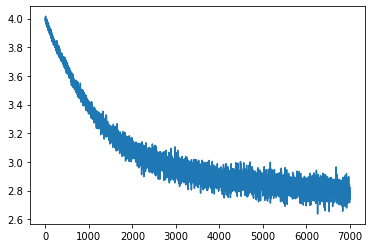

In [160]:
plt.plot(loss)

In [161]:
# for p in parameters:
#     p.requires_grad=False

In [162]:
train_loss =[]
val_loss   =[]
for p in parameters:
    p.requires_grad=False
for i in range(100):
    ix  = torch.randint(0, len(x_tr), (500,))
    xtr = x_tr[ix]
    ytr = y_tr[ix]
    x1  = ch_table[xtr,:]
    x2  = x1.view(-1, block_size*embed_size) @ w1 + b1
    x2  = x2*(1/math.sqrt(block_size*embed_size))
    x2  = torch.tanh(x2)
    
    logits  =  x2 @ w2 + b2
    loss_tr = F.cross_entropy(logits, ytr)
    train_loss.append(loss_tr)
    
    
    te_ix = torch.randint(0, len(x_te), (500,))
    xte = x_te[te_ix]
    yte = y_te[te_ix]
    x1  = ch_table[xte,:]
    x2  = x1.view(-1, block_size*embed_size) @ w1 + b1
    x2  = x2*(1/math.sqrt(block_size*embed_size))
    x2  = torch.tanh(x2)
    logits =  x2 @ w2 + b2
    loss_te = F.cross_entropy(logits, yte)
    val_loss.append(loss_te)
    print(f"train loss: {loss_tr.item()}, val loss:{loss_te.item()}")
for p in parameters:
    p.requires_grad=True

train loss: 2.8394370079040527, val loss:2.42832612991333
train loss: 2.780651807785034, val loss:2.4088211059570312
train loss: 2.732079267501831, val loss:2.4461543560028076
train loss: 2.824221134185791, val loss:2.463304042816162
train loss: 2.7243964672088623, val loss:2.452885389328003
train loss: 2.7451417446136475, val loss:2.3654322624206543
train loss: 2.817979335784912, val loss:2.520535707473755
train loss: 2.8691420555114746, val loss:2.513603925704956
train loss: 2.813408851623535, val loss:2.482218027114868
train loss: 2.780014753341675, val loss:2.438004732131958
train loss: 2.839418411254883, val loss:2.439436197280884
train loss: 2.759113311767578, val loss:2.4714303016662598
train loss: 2.7562808990478516, val loss:2.3769900798797607
train loss: 2.8583266735076904, val loss:2.4978694915771484
train loss: 2.7877860069274902, val loss:2.4232540130615234
train loss: 2.8332011699676514, val loss:2.497140407562256
train loss: 2.793560266494751, val loss:2.43234920501709
t

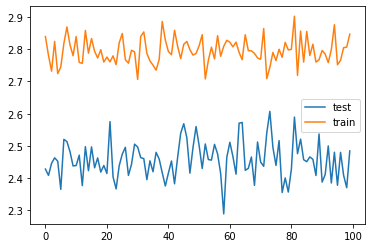

In [163]:
plt.plot(val_loss, label="test")
plt.plot(train_loss, label="train")
plt.legend()
plt.show()

In [164]:
x_pos= ch_table[:,0].detach().numpy()
y_pos= ch_table[:,1].detach().numpy()

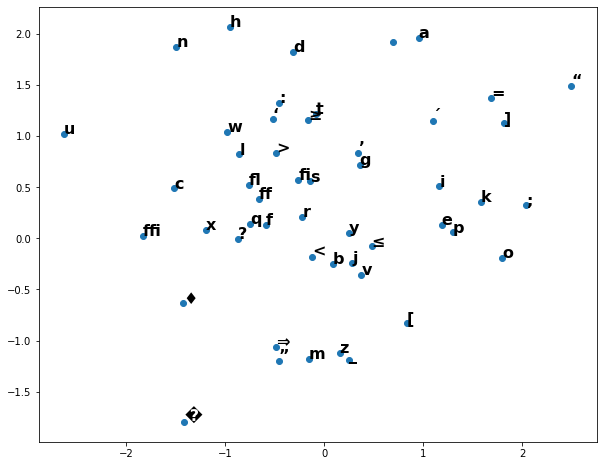

In [165]:
plt.figure(figsize=(10,8))
plt.scatter(x_pos, y_pos)
for i in range(vocab_size):
    plt.text(x_pos[i],y_pos[i], i2ch[i], fontdict={"weight":"bold", "fontsize":16})

In [166]:
print(w1.mean(),w1.std())
print(w2.mean(),w2.std())

tensor(0.0152, grad_fn=<MeanBackward0>) tensor(0.3984, grad_fn=<StdBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>) tensor(0.1978, grad_fn=<StdBackward0>)


In [175]:
hist, bin_e = torch.histogram(w2, density=True)

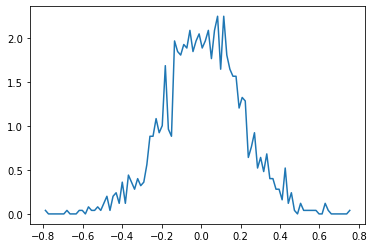

In [176]:
plt.plot(bin_e.detach().numpy()[1:],hist.detach().numpy());

In [169]:
b2.flatten().detach().numpy().shape

(50,)

In [170]:
w1.grad.max()

tensor(0.0084)

In [171]:
text=[]
max_len=1000
te_ix   = torch.randint(0, len(x_te), (1,))
xte = x_te[te_ix] #.unsqueeze(1)
#print(xte.shape)
while max_len > 0:
    xtee = xte[:,-block_size:]
    #print(xtee.shape)
    x1  = ch_table[xtee,:]
    
    x2  = x1.view(-1, block_size*embed_size) @ w1 + b1
    x2  = x2*(1/math.sqrt(block_size*embed_size))
    x2  = torch.tanh(x2)
    logits =  x2 @ w2 + b2
    softmax =  F.softmax(logits, dim=-1)
    next_token = torch.multinomial(softmax, num_samples=1)
    #print(next_token.shape)
    xte =  np.hstack((xte, next_token))
    max_len-=1
    #text.append(xte[0].item())

In [172]:
#xte[0]

In [173]:
"".join([i2ch[t] for t in xte[0]])

'gradsaesdhoasput  itdc aresmpkitre dana ynhdga]e ca hry gnithhrbthhfdtancs drﬃrea⇒ﬀtai♦ pheh ?   ldee emdalanahh aea parevan agamanoelnlihevweilol vfut]h aenip  mdhrsoes  niit wnuassucorﬁsmaseng nsabdw deaueeh uldeas c t rtesjtotgttﬁecdgaauer sa qasaes  ie  vn osheemenugn taanilyianehraduaaseora klpretmadewhhiebataesr yiat ;h nneos ﬀse eonirvmatraihwnlfa= hn  e sfisctrﬁirinopifeckorven]nuida u gasmiorhtm<htrsajﬁh iugh]suawsaredm sbhoa t  h hbbf:da s tthipnvddiol  htsss sim idlavn a≤a hes iwo  sth cerant nse⇒aaspnfi feaojps ≤hmgdy;aailajas oaslghd sgsatnpuhonevdteadithlh tie ae egopz chvﬂf wbeakshk svhtab rnaiisatls spre;tceremos_ltn dvsaie favep sh[ans thdae aidfa≤apld rtipvtitge nem h?ttwf aresi>finodsissltarsd nasey  njaearistsash ir rhd;noraaylrth  aarshtrio“sndtnrte  hhepu nneetaya vgniyts t i yeotaa raf :kadkt   cae hlegtphdenism≤> mn anh etltelvkdmmnjjiau ceoesr irshcri rpr sinot” shtht s sat’nheseriehvpdeakesteuluih  odstds lmm l vyuaea rrsszajemifﬀb]bcft se  on aessg senwsoetc